# Notebook for comparing observing stratergies and their effect on Supernova classification

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed) and the feature extraction methods use least squares here (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [1]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot, example_data
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [5]:
dataset='lsst'

In [6]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [7]:
print(outdir)

output_lsst_no_z/


## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024)

In [38]:
#Data root
rt=os.path.join(example_data, 'SPCC_SUBSET','')
print(rt)

/Users/tallamjr/PhD/project/snmachine/snmachine/example_data/SPCC_SUBSET/


In [25]:
#We can automatically untar the data from here
# if not os.path.exists(rt):
#    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [26]:
dat=sndata.Dataset(rt)

Reading data...
2000 objects read into memory.


In [27]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

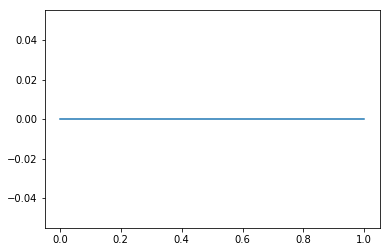

In [28]:
dat.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [29]:
dat.data[dat.object_names[0]]

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,-0.7663,10.48,27.5,ab
0.0160000000033,desr,3.049,7.841,27.5,ab
0.0320000000065,desi,0.4541,9.312,27.5,ab
0.977000000006,desz,4.622,5.329,27.5,ab
1.985,desg,0.8938,3.205,27.5,ab
2.0,desr,3.493,2.427,27.5,ab
2.016,desi,-2.318,4.311,27.5,ab
9.957,desz,39.55,27.34,27.5,ab
10.106,desg,-26.03,25.58,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [40]:
read_from_file=False #We can use this flag to quickly rerun from saved features

out_features_dat=os.path.join(example_data, out_features,'features') #Where we save the extracted features to
subprocess.call(['mkdir', '-p',out_features_dat])

run_name=os.path.join(example_data, out_features,'%s_all' %dataset)
print(run_name)

/Users/tallamjr/PhD/project/snmachine/snmachine/example_data/output_lsst_no_z/features/lsst_all


t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/)

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [41]:
waveFeats=snfeatures.WaveletFeatures()

In [42]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
else:
    wave_features=waveFeats.extract_features(dat,nprocesses=6,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

Performing Gaussian process regression
DES_SN000642.DAT
DES_SN038961.DAT
DES_SN078784.DAT
DES_SN114902.DAT
DES_SN158372.DAT
DES_SN193701.DAT
DES_SN233023.DAT
DES_SN271748.DAT
DES_SN307719.DAT
DES_SN337157.DAT
DES_SN372696.DAT
DES_SN406784.DAT
DES_SN443045.DAT
DES_SN486601.DAT
DES_SN527005.DAT
DES_SN568107.DAT
DES_SN601066.DAT
DES_SN640747.DAT
DES_SN681254.DAT
DES_SN717910.DAT
DES_SN758195.DAT
DES_SN795507.DAT
DES_SN830977.DAT
DES_SN869580.DAT
Time taken for Gaussian process regression 185.72856998443604
Performing wavelet decomposition
Time for wavelet decomposition 95.56159687042236
Running PCA...
Time for PCA 2.8091189861297607


In [43]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

Fitting supernova models...
Models fitted.


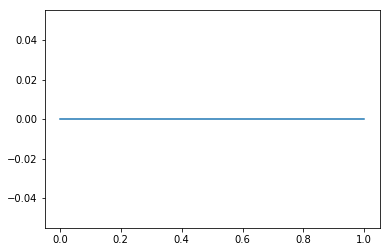

In [44]:
dat.plot_all()

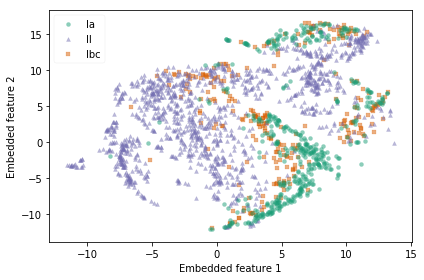

In [45]:
plt.figure()
tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [46]:
nproc=2

In [47]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


### Wavelet features

Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Optimised parameters: {'criterion': 'entropy', 'n_estimators': 400}
Classifier random_forest: AUC = 0.97466008291 FoM = 0.629813664596

Time taken  2.0516922871271768 minutes


/Users/tallamjr/PhD/project/snmachine/snmachine/snclassifier.py:128: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


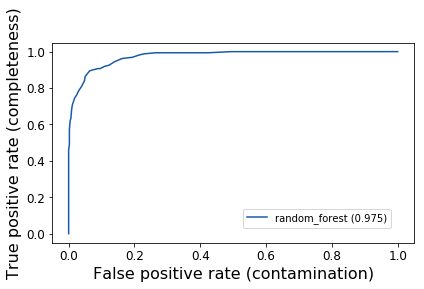

In [48]:
plt.figure()
clss=snclassifier.run_pipeline(wave_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['random_forest'], nprocesses=nproc)